<font size=10>**Natural Language Processing**</font>

<font size=6>**Dallas Area Gym Sentiment Analysis**</font>

By Paul Michel 6/21/2025

![alt text](../gym_sentiment_dallas.png)

In [3]:

import pandas as pd
import datetime as dt

### **Pull Reddit Data around Dallas**

If we want to see  **Dallas gym information**, we should use **conversations in Reddit**, or other social media platforms.  In this analysis, we will use Reddis.  A Reddit App will need to be created from Reddis to create the following credentials.


In [222]:
import praw

# Initialize Reddit API (replace with your credentials)
reddit = praw.Reddit(
    client_id="[you client_id or your Reddit app personal use script ID]",
    client_secret="[your client_secret or your Reddit app secret]",
    user_agent="win:DallasGymSentimentScript:v1.0 (by u/[your reddit user name])",
    username="[your reddit user name]",
    password="[your reddit password]"
)

try:
	print("Reddit Connection Successful (user): " + reddit.user.me())
except Exception as e:
	print("Reddit authentication failed:", e)
	print("Check your client_id, client_secret, username, and password.")


Reddit authentication failed: received 401 HTTP response
Check your client_id, client_secret, username, and password.


## **<font color='blue'>Data Pre-processing</font>**

### **Initial Reddit Search for Dallas Gyms**

To create a **list of Dallas gyms**, we will need to do an initial Reddit Search. We will build this list of gyms to be used later.


In [202]:
# Keywords and location filters
keywords = ["24 Hour Fitness"]
locations = ["Dallas", "DFW", "Plano", "Frisco", "Arlington", "Irving"]
context_words = ["gym", "workout", "membership"]

# Subreddits to search (you can add more)
subreddits = ["Dallas", "Fitness", "gyms", "Plano", "Frisco", "FortWorth"]

results = []

for sub in subreddits:
    print(f"Searching r/{sub}...")
    for post in reddit.subreddit(sub).search("24 Hour Fitness", limit=500):
        text = f"{post.title} {post.selftext}"
        if any(city in text for city in locations) and any(word in text.lower() for word in context_words):
            results.append({
                "id": post.id,
                "subreddit": post.subreddit.display_name,
                "title": post.title,
                "text": text,
                "created_utc": dt.datetime.fromtimestamp(post.created_utc),
                "url": post.url,
                "score": post.score,
                "num_comments": post.num_comments
            })


Searching r/Dallas...
Searching r/Fitness...
Searching r/gyms...
Searching r/Plano...
Searching r/Frisco...
Searching r/FortWorth...


In [203]:
# Save to CSV
df = pd.DataFrame(results)
df.to_csv("dallas_gym_reddit_data.csv", index=False)
print(f"Saved {len(df)} posts to dallas_gym_reddit_data.csv")

Saved 33 posts to dallas_gym_reddit_data.csv


### **Build List of Gym Names**

Extract from Reddit entries any gym names. Will later manually (through code) remove entries not wanted.

In [204]:
import pandas as pd
import re
from collections import Counter

# Load your CSV
df = pd.read_csv("dallas_gym_reddit_data.csv")

# Combine title and text for scanning
texts = (df['title'].fillna('') + ' ' + df['text'].fillna('')).tolist()

# Define gym-related keywords to look for
keywords = ["Fitness", "Gym", "Studio", "Athletic", "Wellness", "Workout", "Boxing", "Pilates", "CrossFit"]

# Regex: Look for capitalized phrases ending with a gym keyword
pattern = re.compile(r'\b([A-Z][a-zA-Z0-9\'\-]*(?:\s+[A-Z][a-zA-Z0-9\'\-]*)*\s(?:' + '|'.join(keywords) + r'))\b')

# Collect all matches
matches = []
for text in texts:
    found = pattern.findall(text)
    matches.extend(found)

# Count most common matches
gym_counts = Counter(matches)

# --- Remove any gym names containing "book", chess, or studio, comedy, dance, etc. (case-insensitive) ---
#
# List of words to exclude (add as many as you want)
exclude_words = ["book", "chess", "studio", "comedy", "dance", "supper", "country"]

# Filter only once, using all exclusion words
filtered_gym_counts = {
    gym: count
    for gym, count in gym_counts.items()
    if not any(ex_word in gym.lower() for ex_word in exclude_words)
}


print("Gyms based on Reddit Query:")
for gym, count in Counter(filtered_gym_counts).most_common(30):
    print(f"{gym}: {count}")

# Extract just the gym names as a list
gym_names = list(filtered_gym_counts.keys())


Gyms based on Reddit Query:
LA Fitness: 3
Sunset Fitness: 2
Metroflex Gym: 2
Reasonable Gym: 2
Powerlifting Gym: 2
The LA Fitness: 1
Hour Fitness: 1
Golds Gym Permanently Closing Golds Gym: 1
Gold's Gym: 1
Optimal Beginning Small-ish Gym Optimal Beginning Small-ish Gym: 1
OSO Climbing Gym: 1
Planet Fitness: 1
F45 Workout: 1
Addison Athletic: 1


### **Normalize Gym Names and List**

To create a **clean list**, and based on observing the list printed above, this is very specific code for this example list of gyms to allow us to clean the list. If the query changes (e.g. another city or area), this code will need to be adjusted based on the list above.


In [215]:
def normalize_gym_name(gym):
    gym = gym.strip()
    # Common fixes
    if gym.lower().replace("'", "") == "golds gym":
        return "Gold's Gym"
    if gym.lower().replace("the ", "") == "la fitness":
        return "LA Fitness"
    if gym.lower().startswith("f45"):
        return "F45 Workout"  # or just "F45" if you prefer
    if gym.lower() == "planet fitness":
        return "Planet Fitness"
    # Remove repeated names (e.g., "Golds Gym Permanently Closing Golds Gym")
    if gym.lower().count("golds gym") > 1:
        return "Gold's Gym"
    if gym.lower().count("optimal beginning small-ish gym") > 1:
        return "Optimal Beginning Small-ish Gym"
    # Other manual mappings as needed
    if gym == "Hour Fitness":
        return "24 Hour Fitness"  # If you know this is the same
    # Default: return the shortest unique part, or just the name as-is
    return gym.split()[0] + " " + gym.split()[-1] if " " in gym else gym

# Example: normalize all gyms
normalized_gyms = set()
for gym in gym_names:
    normalized = normalize_gym_name(gym)
    normalized_gyms.add(normalized)

# Convert to a list for your DataFrame
gym_names = sorted(normalized_gyms)
print(gym_names)


['24 Fitness', 'Addison Athletic', 'Anytime Fitness', 'Blink Fitness', 'Crunch Fitness', 'Equinox', 'F45 Workout', "Gold's Gym", 'LA Fitness', 'Lifetime Fitness', 'Metroflex Gym', 'OSO Gym', 'Optimal Gym', 'Orangetheory', 'Planet Fitness', 'Powerlifting Gym', 'Reasonable Gym', 'Snap Fitness', 'Sunset Fitness', 'YMCA']


In [216]:
# Evaluate new normalized gyms by counting occurrences
normalized_counts = Counter()
for gym, count in filtered_gym_counts.items():
    normalized = normalize_gym_name(gym)
    normalized_counts[normalized] += count

In [217]:
# Now print the normalized counts
print("Most common potential gym names (normalized, excluding 'book'):")
for gym, count in normalized_counts.most_common(30):
    print(f"{gym}: {count}")

# Get the unique normalized gym names as a list
gym_names = list(normalized_counts.keys())
print("\nNormalized gym names list:", gym_names)

Most common potential gym names (normalized, excluding 'book'):
LA Fitness: 4
Sunset Fitness: 2
Gold's Gym: 2
Metroflex Gym: 2
Reasonable Gym: 2
Powerlifting Gym: 2
24 Hour Fitness: 1
Optimal Beginning Small-ish Gym: 1
OSO Gym: 1
Planet Fitness: 1
F45 Workout: 1
Addison Athletic: 1

Normalized gym names list: ['LA Fitness', '24 Hour Fitness', 'Sunset Fitness', "Gold's Gym", 'Optimal Beginning Small-ish Gym', 'OSO Gym', 'Metroflex Gym', 'Reasonable Gym', 'Planet Fitness', 'Powerlifting Gym', 'F45 Workout', 'Addison Athletic']


In [218]:
# --- Your gym_names list (from earlier) ---
addittional_gym_names_to_search = [
    "24 Hour Fitness", "Planet Fitness", "LA Fitness", "Gold's Gym",
    "Anytime Fitness", "Crunch Fitness", "Equinox", "Lifetime Fitness",
    "YMCA", "Snap Fitness", "Orangetheory", "F45", "Blink Fitness"
]
gym_names = list(set(addittional_gym_names_to_search + gym_names))

# **<font color='blue'>Search Reddit</font>**

### **Search Reddit - This is the main search utilizing also the list of gyms names above**

We will now do a **comprehensive search** in Reddit for Dallas Gyms. We will **build a dataframe** that can be used to collect, count, evaluate, and visualize sentiment concerning Dallas gyms.

In [219]:
# --- Filters and subreddits ---
# gym_names
locations = ["Dallas", "DFW", "Plano", "Frisco", "Arlington", "Irving"]
context_words = ["gym", "workout", "membership"]
subreddits = ["Dallas", "Fitness", "gyms", "Plano", "Frisco", "FortWorth"]

# --- Optional: Add broad keywords to catch more posts ---
search_terms = gym_names + ["gym", "fitness", "workout"]

results = []

# --- Search and collect posts ---
for sub in subreddits:
    print(f"Searching r/{sub}...")
    for term in search_terms:
        try:
            for post in reddit.subreddit(sub).search(term, limit=100):  # Lower limit to avoid rate limits
                text = f"{post.title or ''} {post.selftext or ''}".strip()
                # Filter for relevant locations and context words
                if any(city in text for city in locations) and any(word in text.lower() for word in context_words):
                    # Add gym mention flags
                    gym_mentions = {
                        gym.replace(" ", "_").replace("'", "").replace("-", "_"): int(gym.lower() in text.lower())
                        for gym in gym_names
                    }
                    gyms_mentioned = [gym for gym in gym_names if gym.lower() in text.lower()]
                    
                    results.append({
                        "id": post.id,
                        "user": post.author.name if post.author else None,
                        "subreddit": post.subreddit.display_name,
                        "title": post.title,
                        "text": text,
                        "created_utc": dt.datetime.fromtimestamp(post.created_utc),
                        "url": post.url,
                        "score": post.score,
                        "num_comments": post.num_comments,
                        "gym": ", ".join(gyms_mentioned), 
                        **gym_mentions  # Unpack gym flags as columns
                    })
        except Exception as e:
            print(f"Error searching for '{term}' in r/{sub}: {e}")

# --- Deduplicate and save ---
df = pd.DataFrame(results).drop_duplicates(subset="id")
df.to_csv("dallas_gym_sentiment_ready.csv", index=False)
print(f"Saved {len(df)} unique posts to dallas_gym_sentiment_ready.csv")


Searching r/Dallas...
Searching r/Fitness...
Searching r/gyms...
Searching r/Plano...
Searching r/Frisco...
Searching r/FortWorth...
Saved 272 unique posts to dallas_gym_sentiment_ready.csv


In [220]:
# Display results
df.head(2)

,id,user,subreddit,title,text,created_utc,url,score,num_comments,gym,...,Sunset_Fitness,Metroflex_Gym,Snap_Fitness,F45_Workout,Anytime_Fitness,Reasonable_Gym,Planet_Fitness,Golds_Gym,24_Hour_Fitness,Lifetime_Fitness
0,19bittd,jakeimber,Dallas,Third Places in Dallas,"Third Places in Dallas In the 1980s, a guy nam...",2024-01-20 10:52:26,https://www.reddit.com/r/Dallas/comments/19bit...,330,273,,...,0,0,0,0,0,0,0,0,0,0
1,1bobfk5,screamingfrommyeyes,Dallas,Gym recommendations?,Gym recommendations? I live in NE Dallas (gree...,2024-03-26 09:00:38,https://www.reddit.com/r/Dallas/comments/1bobf...,3,39,"Equinox, Planet Fitness",...,0,0,0,0,0,0,1,0,0,0


# **<font color='blue'>Sentiment Analysis</font>**

In [221]:
# !pip install vaderSentiment textblob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Analysis with VADER<br>
VADER used for Reddit and good for short text.

In [106]:
#df = pd.read_csv("dallas_gym_sentiment_ready.csv")
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    if isinstance(text, str):
        return analyzer.polarity_scores(text)['compound']
    else:
        return 0  # or np.nan if you prefer

df['sentiment_vader'] = df['text'].apply(vader_sentiment)



# Sentiment Analysis with TextBlob<br>
TextBlob is also popular and easy to use.

In [107]:
def textblob_sentiment(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    else:
        return 0  # or np.nan if you prefer

df['sentiment_textblob'] = df['text'].apply(textblob_sentiment)


# Sentiment by Gym (Example: LA Fitness)
You can analyze sentiment for each gym by filtering the DataFrame for posts that mention that gym.

In [108]:
# Example: LA Fitness
la_fitness_posts = df[df['LA_Fitness'] == 1]
print("LA Fitness Sentiment (VADER):", la_fitness_posts['sentiment_vader'].mean())
print("LA Fitness Sentiment (TextBlob):", la_fitness_posts['sentiment_textblob'].mean())


LA Fitness Sentiment (VADER): 0.7966545454545456
LA Fitness Sentiment (TextBlob): 0.17728310607989753


# Sentiment by All Gyms
Looping through all gyms and calculate average sentiment.

Equinox - VADER: 0.700, TextBlob: 0.275
Addison Athletic - VADER: -0.962, TextBlob: 0.090
Powerlifting Gym - VADER: 0.425, TextBlob: 0.153
LA Fitness - VADER: 0.797, TextBlob: 0.177
Orangetheory - VADER: 0.865, TextBlob: 0.186
YMCA - VADER: 0.501, TextBlob: 0.028
F45 - VADER: 0.998, TextBlob: 0.212
Sunset Fitness - VADER: 1.000, TextBlob: 0.191
Metroflex Gym - VADER: 0.491, TextBlob: 0.208
F45 Workout - VADER: 0.998, TextBlob: 0.212
Anytime Fitness - VADER: 0.958, TextBlob: 0.181
Reasonable Gym - VADER: 0.939, TextBlob: 0.037
Planet Fitness - VADER: 0.830, TextBlob: 0.252
24 Hour Fitness - VADER: 0.691, TextBlob: 0.075
Lifetime Fitness - VADER: 0.494, TextBlob: 0.127


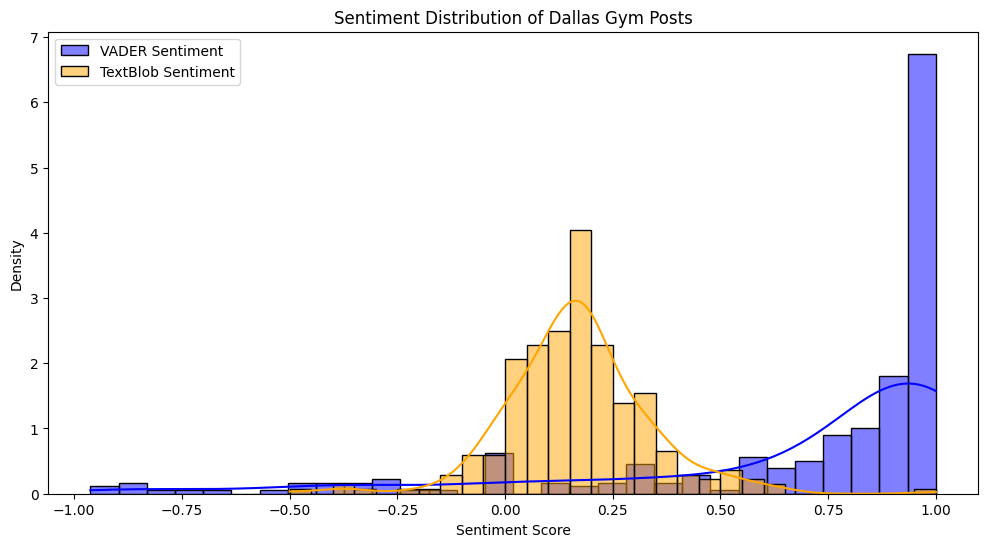

Sentiment scores saved to dallas_gym_sentiment_scores.csv


,id,user,subreddit,title,text,created_utc,url,score,num_comments,gym,...,Snap_Fitness,F45_Workout,Anytime_Fitness,Reasonable_Gym,Planet_Fitness,Golds_Gym,24_Hour_Fitness,Lifetime_Fitness,sentiment_vader,sentiment_textblob
0,19bittd,jakeimber,Dallas,Third Places in Dallas,"Third Places in Dallas In the 1980s, a guy nam...",2024-01-20 10:52:26,https://www.reddit.com/r/Dallas/comments/19bit...,330,273,,...,0,0,0,0,0,0,0,0,0.9872,0.199537
1,1bobfk5,screamingfrommyeyes,Dallas,Gym recommendations?,Gym recommendations? I live in NE Dallas (gree...,2024-03-26 09:00:38,https://www.reddit.com/r/Dallas/comments/1bobf...,3,39,"Equinox, Planet Fitness",...,0,0,0,0,1,0,0,0,0.9534,0.383255


In [109]:
gym_cols = [col for col in df.columns if col.replace("_", " ") in gym_names or col in gym_names]
for gym_col in gym_cols:
    gym_posts = df[df[gym_col] == 1]
    if len(gym_posts) > 0:
        print(f"{gym_col.replace('_', ' ')} - VADER: {gym_posts['sentiment_vader'].mean():.3f}, TextBlob: {gym_posts['sentiment_textblob'].mean():.3f}")

# Plotting sentiment distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['sentiment_vader'], bins=30, kde=True, color='blue', label='VADER Sentiment', stat='density')
sns.histplot(df['sentiment_textblob'], bins=30, kde=True, color='orange', label='TextBlob Sentiment', stat='density')
plt.title('Sentiment Distribution of Dallas Gym Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Save the DataFrame with sentiment scores
df.to_csv("dallas_gym_sentiment_scores.csv", index=False)
print("Sentiment scores saved to dallas_gym_sentiment_scores.csv")
# Display the first few rows of the DataFrame with sentiment scores
df.head(2)

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# (Assume df is already loaded and has the sentiment columns)
gym_cols = [col for col in df.columns if col.replace("_", " ") in gym_names or col in gym_names]
gym_names_clean = [col.replace("_", " ") for col in gym_cols]

# Calculate average sentiment per gym
results = []
for gym_col in gym_cols:
    gym_posts = df[df[gym_col] == 1]
    if len(gym_posts) > 0:
        results.append({
            "Gym": gym_col.replace("_", " "),
            "VADER": gym_posts['sentiment_vader'].mean(),
            "TextBlob": gym_posts['sentiment_textblob'].mean()
        })
results_df = pd.DataFrame(results)


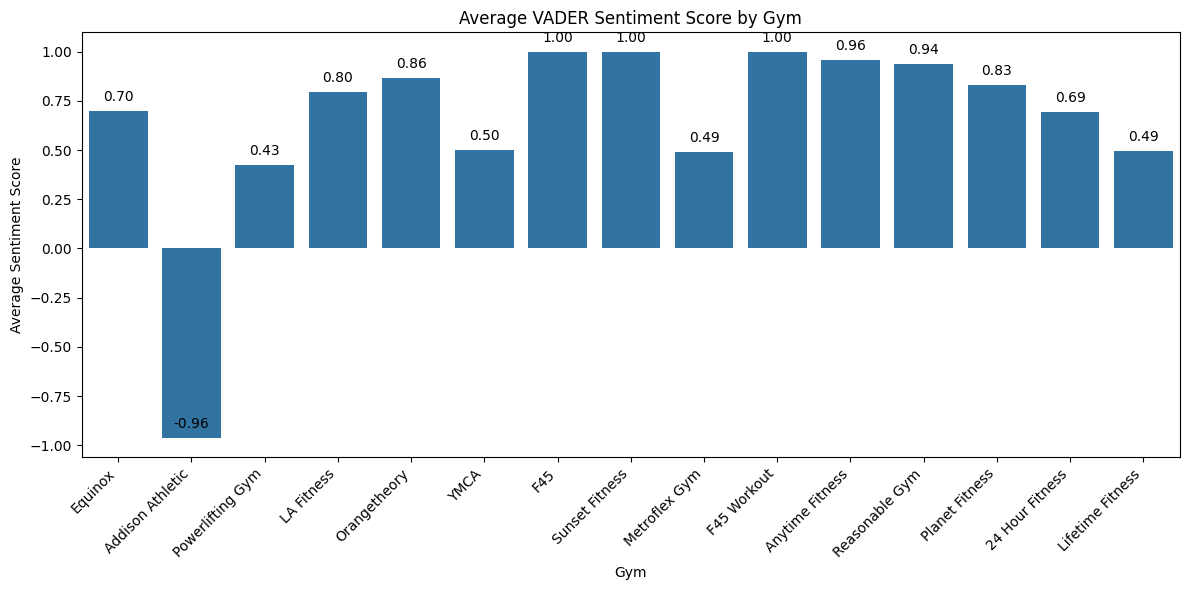

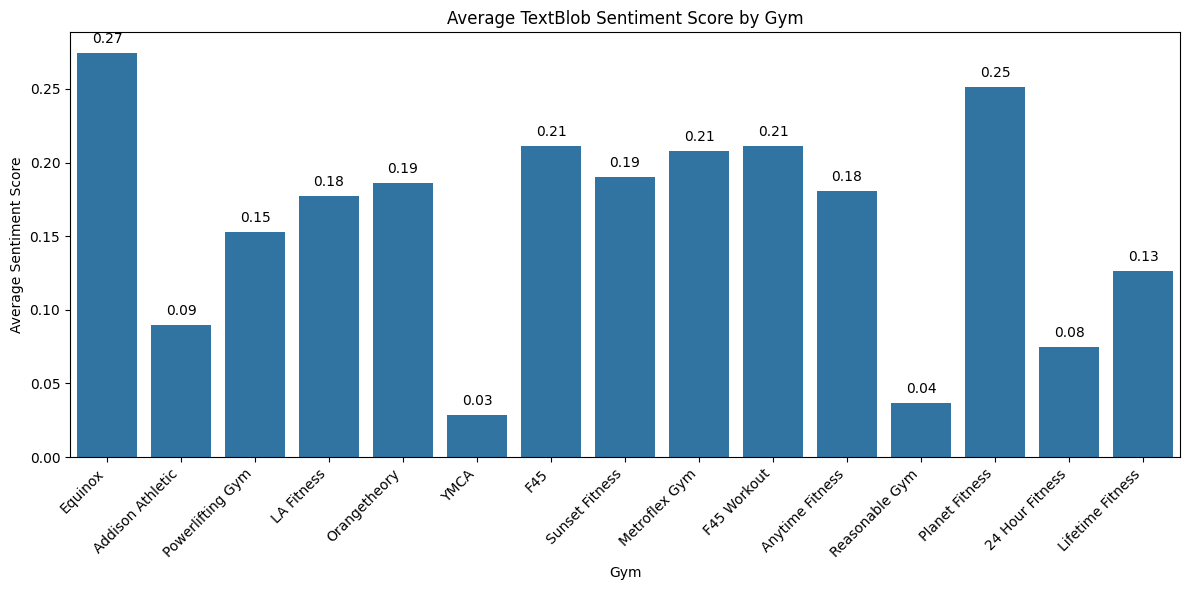

In [112]:
# For VADER
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Gym', y='VADER', data=results_df)
plt.xticks(rotation=45, ha="right")
plt.title('Average VADER Sentiment Score by Gym')
plt.ylabel('Average Sentiment Score')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.show()

# For TextBlob
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Gym', y='TextBlob', data=results_df)
plt.xticks(rotation=45, ha="right")
plt.title('Average TextBlob Sentiment Score by Gym')
plt.ylabel('Average Sentiment Score')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.show()


### **Word Analysis (NLP)**

We will now evaluate the words, especially around positive sentiment.

In [113]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('vader_lexicon')

# Load your DataFrame (or use your current df)
df = pd.read_csv("./dallas_gym_sentiment_scores.csv")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joemi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\joemi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Define Function to Extract Positive Words
This function will:

Tokenize the text.

Check each word against VADER’s lexicon for positive sentiment.

Return a list of positive words.

In [114]:
sid = SentimentIntensityAnalyzer()
vader_lexicon = sid.lexicon

def extract_positive_words(text):
    if not isinstance(text, str):
        return []
    words = word_tokenize(text)
    positive_words = []
    for word in words:
        if word.lower() in vader_lexicon and vader_lexicon[word.lower()] > 0:
            positive_words.append(word)
    return positive_words


# Apply to Gym-Related Posts
Example for one gym, **'LA Fitness'**
Extract positive words only from posts that mention a specific gym, filter for “LA Fitness”:

In [115]:
la_fitness_posts = df[df['LA_Fitness'] == 1]
la_fitness_texts = la_fitness_posts['text'].tolist()

all_positive_words = []
for text in la_fitness_texts:
    all_positive_words.extend(extract_positive_words(text))

print("Positive words from LA Fitness posts:", all_positive_words)


Positive words from LA Fitness posts: ['Fitness', 'help', 'huge', 'help', 'like', 'good', 'Strong', 'want', 'like', 'appreciate', 'help', 'sincere', 'gratitude', 'joy', 'helping', 'Fitness', 'loving', 'sure', 'Hopefully', 'strong', 'fit', 'likes', 'Fitness', 'Fitness', 'Fitness', 'Fitness', 'Fit', 'Fitness', 'Fitness', 'Fitness', 'Fitness', 'help', 'fitness', 'joke', 'Fitness', 'huge', 'want', 'CLEAN', 'well', 'good', 'free', 'solid', 'adequate', 'good', 'free', 'wise', 'Fitness', 'Fitness', 'Fitness', 'Fitness', 'honoring', 'convince', 'lol', 'fitness', 'pretty', 'lol', 'pretty', 'good', 'like', 'Thanks', 'solid', 'solid', 'fitness', 'fitness', 'Fitness', 'nice', 'Fitness', 'good', 'play', 'play', 'want', 'fitness', 'Fitness', 'want', 'Best', 'Fitness', 'Fitness', 'Fitness', 'good', 'help', 'best', 'friends', 'enjoyable', 'Fitness', 'feeling', 'Best', 'Fit', 'Fitness', 'love']


### **Word Analysis (NLP) - All Gyms**

We will continue to evaluate the words around positive sentiment.
Get positive words from all gym posts (any gym):

In [127]:
gym_cols = [col for col in df.columns if col.replace("_", " ") in gym_names or col in gym_names]
gym_posts = df[df[gym_cols].sum(axis=1) > 0]
gym_texts = gym_posts['text'].tolist()

all_positive_words = []
for text in gym_texts:
    all_positive_words.extend(extract_positive_words(text))

print("Positive words from all gym posts:", all_positive_words)


Positive words from all gym posts: ['nicer', 'fitness', 'worth', 'enjoying', 'perfect', 'favorite', 'like', 'like', 'welcome', 'like', 'like', 'rich', 'Best', 'great', 'loved', 'well', 'casual', 'nicest', 'Thank', 'join', 'increase', 'like', 'great', 'like', 'free', 'Pretty', 'enjoy', 'fitness', 'Love', 'Appreciate', 'festival', 'free', 'like', 'enjoyed', 'great', 'relieve', 'recommend', 'efficient', 'great', 'free', 'discounted', 'helps', 'Optimal', 'kind', 'pretty', 'kind', 'like', 'fitness', 'interested', 'fitness', 'like', 'gain', 'fit', 'interests', 'care', 'wish', 'want', 'Please', 'Thanks', 'free', 'Thanks', 'great', 'Fitness', 'help', 'huge', 'help', 'like', 'good', 'Strong', 'want', 'like', 'appreciate', 'help', 'sincere', 'gratitude', 'joy', 'helping', 'free', 'helpful', 'welcome', 'welcome', 'great', 'Want', 'Comedy', 'Holidays', 'Enchanted', 'Adventure', 'Faith', 'Holiday', 'Worth', 'Fair', 'Favorite', 'Play', 'Worth', 'Great', 'FREE', 'Worth', 'Festival', 'Freedom', 'Matte

### **Categorize Sentiment in 3 buckets**

Determine the Sentiment Category, **Positive**, **Negative**, or **Neutrual** for each gym


In [128]:
def get_sentiment(text):
    if not isinstance(text, str):
        return "Neutral"
    scores = sid.polarity_scores(text)
    if scores['compound'] >= 0.8 and scores['pos'] > scores['neg']:
        return "Positive"
    elif scores['compound'] < 0.8 and scores['compound'] >= .3:
        return "Neutral"
    elif scores['compound'] < .3 and scores['neg'] > scores['pos']:
        return "Negative"
    else:
        return "Neutral"


In [129]:
# Add new columns for VADER sentiment classification
df['sentiment_vader_label'] = df['text'].apply(get_sentiment)

# (Optional) If you want separate columns for each sentiment (one-hot style)
for label in ["Positive", "Negative", "Neutral"]:
    df[f'is_vader_{label.lower()}'] = (df['sentiment_vader_label'] == label).astype(int)


In [130]:
print(df[['user','gym','text', 'sentiment_vader_label']].head())


                  user                      gym  \
0            jakeimber                      NaN   
1  screamingfrommyeyes  Equinox, Planet Fitness   
2         ketchupsalad                      NaN   
3      MidnightEconomy                  Equinox   
4         Europa_Gains                  Equinox   

                                                text sentiment_vader_label  
0  Third Places in Dallas In the 1980s, a guy nam...              Positive  
1  Gym recommendations? I live in NE Dallas (gree...              Positive  
2  Best gyms in Dallas? Hello r/Dallas \n\nMy wif...              Positive  
3  Why are all the luxury gyms in Dallas dated? I...               Neutral  
4  Best Luxury Gym? I have done equinox, and they...              Positive  


In [131]:
print("Sentiment distribution (VADER):")
print(df['sentiment_vader_label'].value_counts())


Sentiment distribution (VADER):
sentiment_vader_label
Positive    169
Neutral      81
Negative     22
Name: count, dtype: int64


In [132]:
# Explode the 'gym' column so each gym in the string gets its own row
df_exploded = df.assign(gym=df['gym'].str.split(', ')).explode('gym')

# Remove empty strings if any (posts that mention no gyms)
df_exploded = df_exploded[df_exploded['gym'] != '']

gym_sentiment = df_exploded.groupby(["gym", "sentiment_vader_label"]).size().unstack(fill_value=0)


In [133]:
gym_sentiment["percent_positive"] = gym_sentiment["Positive"] / gym_sentiment.sum(axis=1)
gym_sentiment["overall_sentiment_score"] = (
    (gym_sentiment["Positive"] * 1) + (gym_sentiment["Neutral"] * 0) + (gym_sentiment["Negative"] * -1)
) / gym_sentiment.sum(axis=1)


In [134]:
gym_sentiment.head(20)


sentiment_vader_label,Negative,Neutral,Positive,percent_positive,overall_sentiment_score
gym,,,,,
24 Hour Fitness,0,3,2,0.400000,0.370370
Addison Athletic,1,0,0,0.000000,-1.000000
Anytime Fitness,0,0,3,1.000000,0.750000
Equinox,0,3,7,0.700000,0.654206
F45,0,0,1,1.000000,0.500000
F45 Workout,0,0,1,1.000000,0.500000
Gold's Gym,1,1,0,0.000000,-0.500000
LA Fitness,0,4,7,0.636364,0.601562
Lifetime Fitness,1,0,2,0.666667,0.272727


In [135]:
gym_sentiment.to_csv("gym_sentiment_summary.csv")


### **Analysis of Top Gyms**

1. If we want to see the **most favorably gyms overall**, we should use the **overall sentiment score**, which accounts for both positive and negative sentiment weights.
2. Select the **top 10 gyms** using `.head(10)`.
3. Print the sorted DataFrame to see the **best 10 gyms based on sentiment**.


In [136]:
# Sort gyms by highest overall sentiment score first and select top 10
top_10_gyms = gym_sentiment.sort_values("overall_sentiment_score", ascending=False).head(10)

# Display top 10 gyms based on overall sentiment score
print("Top 10 Gyms Based on Overall Sentiment Score")
display(top_10_gyms)


Top 10 Gyms Based on Overall Sentiment Score


sentiment_vader_label,Negative,Neutral,Positive,percent_positive,overall_sentiment_score
gym,,,,,
Planet Fitness,0,2,10,0.833333,0.779221
Anytime Fitness,0,0,3,1.000000,0.750000
Sunset Fitness,0,0,2,1.000000,0.666667
Equinox,0,3,7,0.700000,0.654206
LA Fitness,0,4,7,0.636364,0.601562
Orangetheory,0,2,3,0.600000,0.535714
Reasonable Gym,0,0,1,1.000000,0.500000
F45 Workout,0,0,1,1.000000,0.500000
F45,0,0,1,1.000000,0.500000


C:\Users\joemi\AppData\Local\Temp\ipykernel_38308\3808499869.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


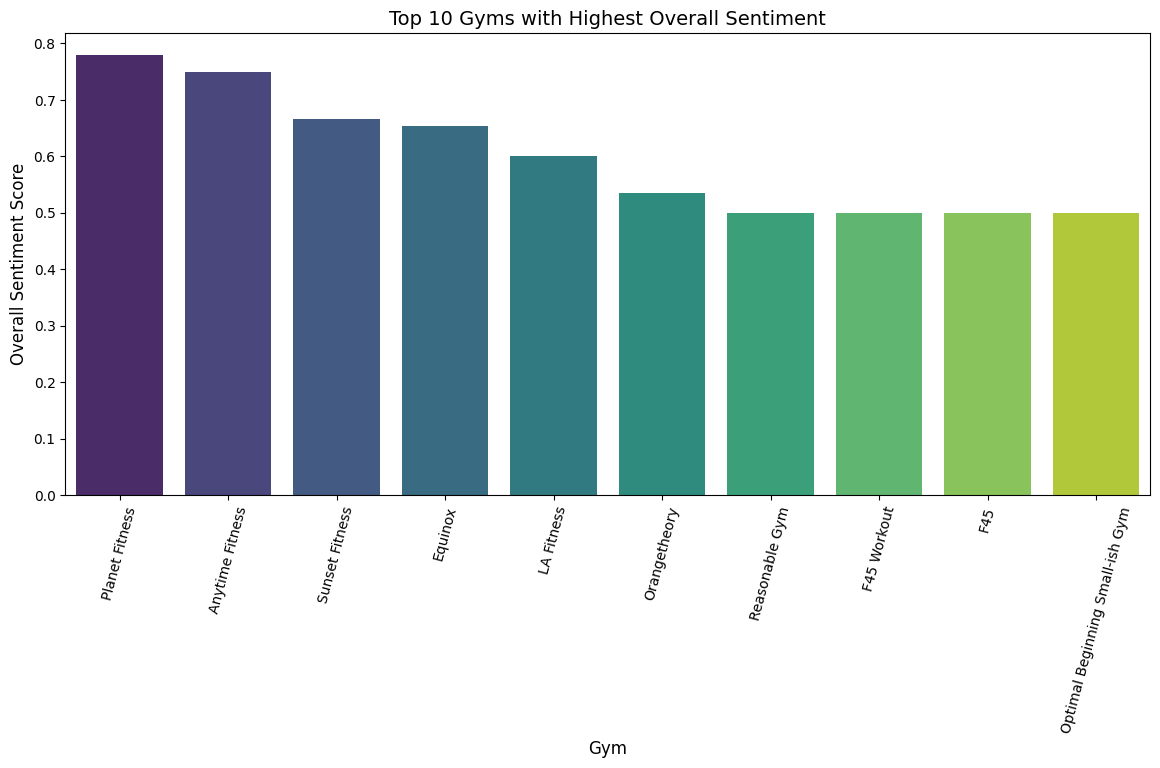

In [137]:
plt.figure(figsize=(14, 6))
sns.barplot(
    x=top_10_gyms.index,
    y=top_10_gyms["overall_sentiment_score"],
    palette="viridis"
)
plt.xticks(rotation=75)
plt.title("Top 10 Gyms with Highest Overall Sentiment", fontsize=14)
plt.xlabel("Gym", fontsize=12)
plt.ylabel("Overall Sentiment Score", fontsize=12)
plt.show()


In [138]:
top_10_gyms.to_csv("top_10_gyms.csv")


### **Sentiment Distribution Across All Gyms**

- To understand the overall sentiment composition (Positive, Neutral, Negative) across all comments.

C:\Users\joemi\AppData\Local\Temp\ipykernel_38308\3093579114.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["sentiment_vader_label"], palette="coolwarm")


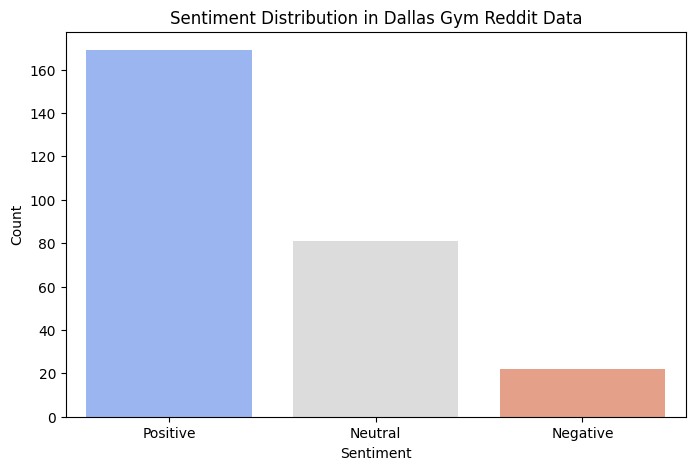

In [139]:
plt.figure(figsize=(8,5))
sns.countplot(x=df["sentiment_vader_label"], palette="coolwarm")
plt.title("Sentiment Distribution in Dallas Gym Reddit Data")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


**WordCloud**
- Generates a visual representation of frequently occurring words in text data.
- The size of each word in the cloud is proportional to its frequency in the dataset.

Let's generate the word cloud for the positive comments
1. Filters the dataset to select **only "Positive"** sentiment comments.
2. Converts these comments into a **single large string** where words are separated by spaces.
3. This prepares the data for **word frequency analysis**.


In [182]:
import re

# List of city names and other words to remove
cities_to_remove = ["Dallas", "DFW", "Plano", "Frisco", "Arlington", "Irving", "Fort Worth", "DFW Metroplex", "Dallas-Fort Worth", "DFW Area", "Dallas Area", "Dallas Metroplex"]
other_words_to_remove = ["clyde","warren","art","artist","m","love","festival","looking","30pm","branch","theatre","exhibit","music","hall","texas","library","museum","fair","cultural","center","musical","park","https", "facebook", "reddit", "prekindle", "eventbrite", "meetup", "gym", "fitness", "workout", "membership", "24 Hour Fitness", "LA Fitness", "Gold's Gym", "Planet Fitness", "Anytime Fitness", "Crunch Fitness", "Equinox", "Lifetime Fitness", "YMCA", "Snap Fitness", "Orangetheory", "F45 Workout"]
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
months_abrev = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Novr", "Dec"]
months_full = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]    
more_words = ["Comedy","Show","Dance","Tour","Book","Club","Live","Arts","Performance","Granada","Stand","Party","Exhibition","Alamo", "Drafthouse","Gallery","Crow","Collection","Ellum","Clyde", "Warren","Concert", "Theater","Art", "Festival", "Looking", "30pm", "Branch", "Theatre", "Exhibit", "Music", "Hall", "Texas", "Library", "Museum", "Fair", "Cultural", "Center", "Musical", "Park"]
letters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
airlines = ["American Airlines", "Southwest Airlines", "United Airlines", "Delta Air Lines", "Alaska Airlines", "JetBlue Airways", "Spirit Airlines", "Frontier Airlines", "Allegiant Air", "Sun Country Airlines"]

# Combine all words and patterns to remove
words_to_remove = cities_to_remove + other_words_to_remove + days_of_week + months_abrev + months_full + more_words + letters + airlines


In [180]:
def clean_text(text, remove_words):
    # Remove URLs and anything starting with http or www
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.IGNORECASE)
    # Remove specified words (case-insensitive)
    for word in remove_words:
        text = re.sub(r'\b' + re.escape(word) + r'\b', '', text, flags=re.IGNORECASE)
    # Remove extra spaces, tabs, and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    return text


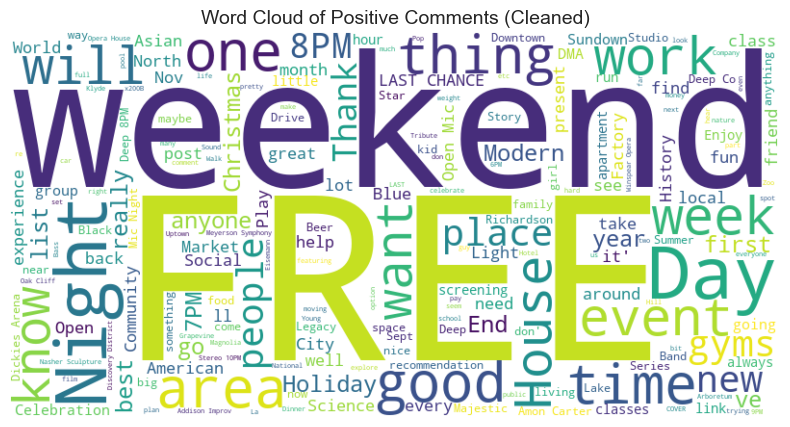

In [183]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Get all positive text (use your actual sentiment column name)
positive_text = " ".join(df[df["sentiment_vader_label"] == "Positive"]["text"].astype(str))

# Clean the text
clean_positive_text = clean_text(positive_text, words_to_remove)

# Generate and plot word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(clean_positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Positive Comments (Cleaned)", fontsize=14)
plt.show()


- **Bigger words** appear more frequently in positive comments.
- Words like "**Free,**" "**Weekend,**" "**Night,**" "***8PM***", and smaller words like "**Holiday,**" "**Modern**" indicate **members' excitement and positive reactions** and likely give hints of what may be important in the sentiments.

C:\Users\joemi\AppData\Local\Temp\ipykernel_38308\1587565856.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_gyms.index, y=top_10_gyms["overall_sentiment_score"], palette="viridis")


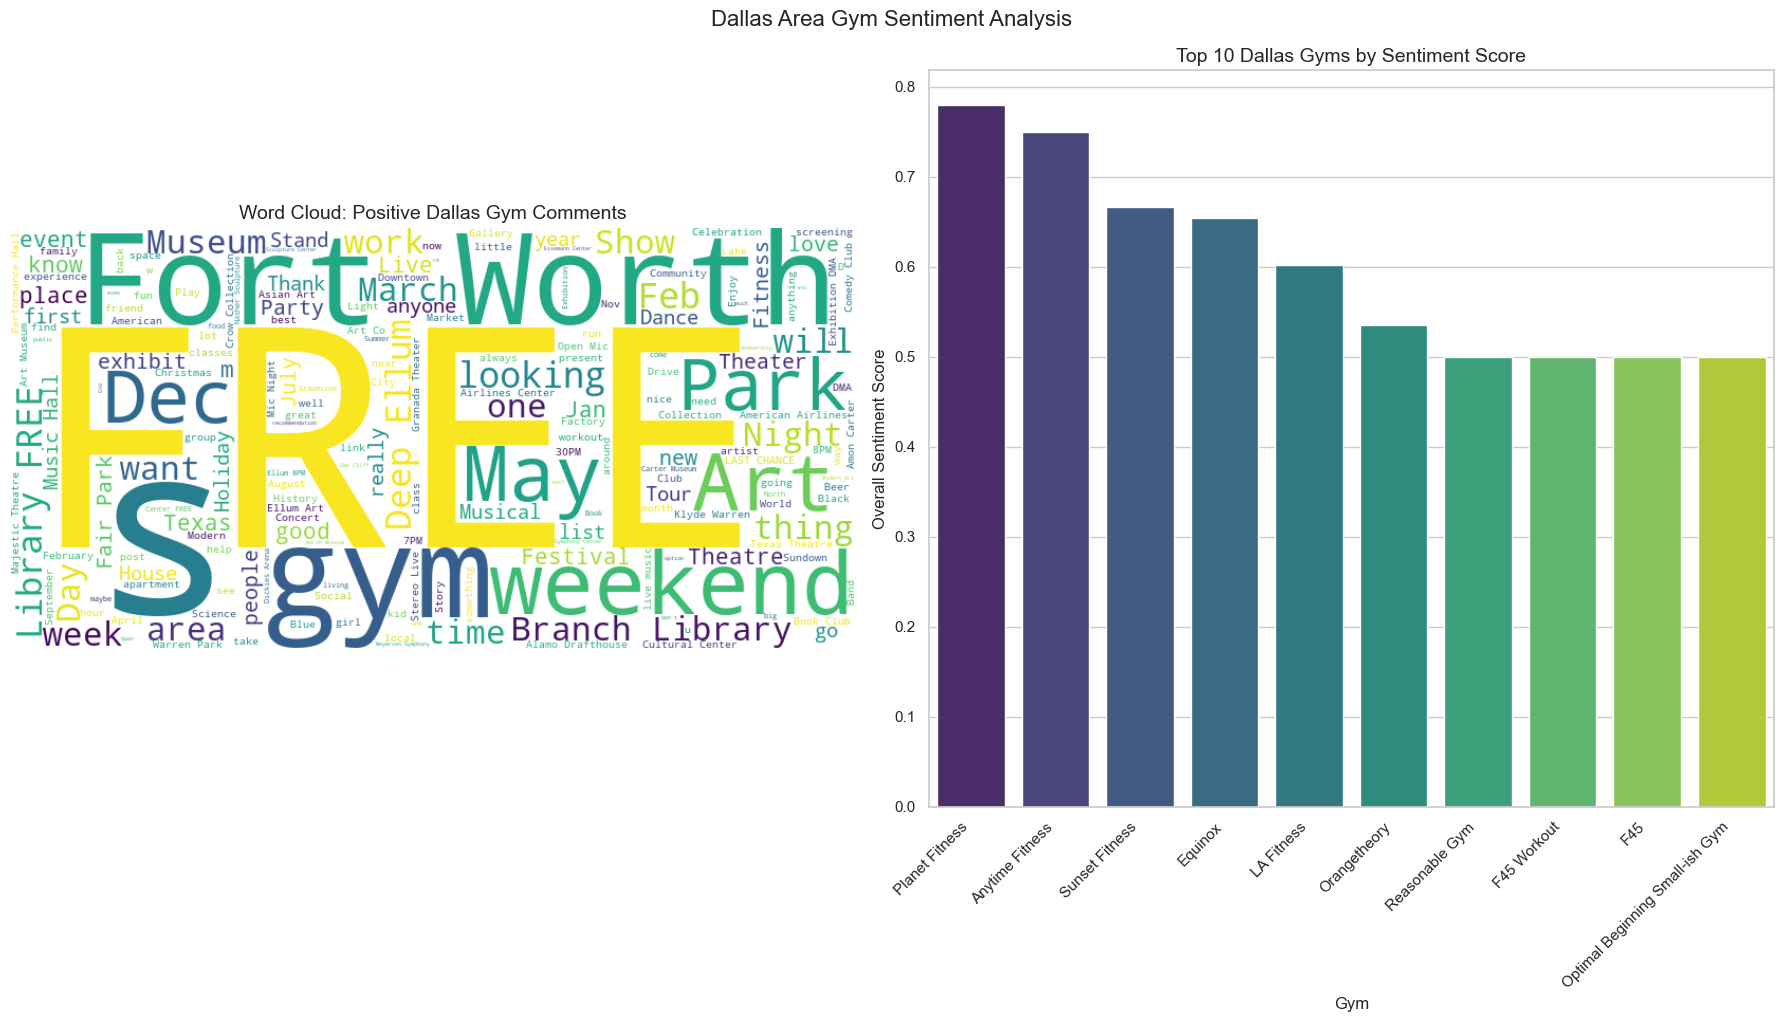

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# --- 1. Clean Text for Word Cloud (same as before) ---
def clean_text(text, remove_words):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.IGNORECASE)
    # Remove specified words
    for word in remove_words:
        text = re.sub(r'\b' + re.escape(word) + r'\b', '', text, flags=re.IGNORECASE)
    # Remove extra spaces, tabs, and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# List of words to remove
cities_to_remove = ["Dallas", "DFW", "Plano", "Frisco", "Arlington", "Irving"]
other_words_to_remove = ["https", "facebook", "reddit", "prekindle"]
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
words_to_remove = cities_to_remove + other_words_to_remove + days_of_week

# --- 2. Prepare for Word Cloud ---
positive_text = " ".join(df[df["sentiment_vader_label"] == "Positive"]["text"].astype(str))
clean_positive_text = clean_text(positive_text, words_to_remove)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(clean_positive_text)

# --- 3. Prepare for Bar Plot (top 10 gyms by sentiment) ---
top_10_gyms = gym_sentiment.sort_values("overall_sentiment_score", ascending=False).head(10)

# --- 4. Create a Figure with Both Plots ---
plt.figure(figsize=(18, 10))

# Word cloud (left)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Positive Dallas Gym Comments", fontsize=14)

# Bar plot (right)
plt.subplot(1, 2, 2)
sns.barplot(x=top_10_gyms.index, y=top_10_gyms["overall_sentiment_score"], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Dallas Gyms by Sentiment Score", fontsize=14)
plt.xlabel("Gym", fontsize=12)
plt.ylabel("Overall Sentiment Score", fontsize=12)

plt.tight_layout()
plt.suptitle("Dallas Area Gym Sentiment Analysis", fontsize=16, y=1.02)
plt.show()
